In [1]:
import json
import os
import random

from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize, MinMaxScaler
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.cm as plt_cm
import matplotlib.colors as plt_colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import soundfile as sf

import utils.audio

In [2]:
random.seed(1337)
random_state = 451
np.random.seed(42)

In [3]:
# Constants
SILENCE_CLASS = 0
VERSION = 2

# Variables
audio_file_path = '../../projects/tomomibot/material/tomomi-original.wav'
experiment_name = 'tomomi-original'

args = {
    'block_len_sec': 120, # Read audio file in blocks of x seconds
    'trim_top_db': 10,    # dB threshold for trimming audio slices

    'n_components': 3,    # Number of PCA components
    'n_clusters': 99,     # Number of KMeans clusters (1. "sound classes") + silence class
    
    'outliers': 0.005,    # Threshold to consider PCA points as outliers
    'n_filter_steps': 1,  # How often should we check for outliers

    'kernel_size': 8,     # Kernel size to measure average volume
    
    'durations': [        # Definition of durations (2. "duration classes")
        100,
        250,
        500,
        750,
        1000,
        1250,
        1500,
        2000,
        4000,
        8000,
    ],

    'n_dynamics': 10,     # Number of dynamic steps (3. "dynamics classes")
}

args['n_durations'] = len(args['durations'])

In [4]:
# Read audio data
info = sf.info(audio_file_path)
y_len = info.frames
sr = info.samplerate
blocksize = sr * args['block_len_sec']
block_num = y_len // blocksize

block_gen = sf.blocks(audio_file_path,
                      blocksize=blocksize,
                      always_2d=True,
                      dtype='float32')

print(info)
print('')

print('Start reading {} blocks ...'.format(block_num + 1))

data = []
id_counter = 2 # id = 1 is for our silence class
for block_no, bl in enumerate(block_gen):
    offset = blocksize * block_no
    
    # Downmix to mono
    y = np.mean(bl, axis=1)
    
    # Detect onsets
    onsets = utils.audio.detect_onsets(y, sr=sr)
    
    # Slice audio into parts, analyze mffcs and save them
    slices = utils.audio.slice_audio(y, onsets, offset=offset, top_db=args['trim_top_db'])
    for i in range(len(slices) - 1):
        y_slice = slices[i][0]
        
        # Calculate MFCCs
        mfcc = utils.audio.mfcc_features(y_slice, sr)
        
        # RMS Volume
        rms = librosa.feature.rms(y=y_slice)
        
        # Keep all information stored
        data.append({'sound_id': id_counter,
                     'mfcc': mfcc.tolist(),
                     'rms': np.max(rms),
                     'start': np.uint32(slices[i][1]).item(),
                     'end': np.uint32(slices[i][2]).item()})
        
        id_counter += 1
        
    print('Reading block {0} ({1:.0f}%) w. {2} slices'.format(block_no + 1,
                                                              block_no / block_num * 100,
                                                              len(slices)))
    
print('Finished reading {} events ...'.format(id_counter - 2))

../../projects/tomomibot/material/tomomi-original.wav
samplerate: 44100 Hz
channels: 1
duration: 5:4e+01:11.868 h
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

Start reading 173 blocks ...
Reading block 1 (0%) w. 142 slices
Reading block 2 (1%) w. 234 slices
Reading block 3 (1%) w. 271 slices
Reading block 4 (2%) w. 391 slices
Reading block 5 (2%) w. 323 slices
Reading block 6 (3%) w. 235 slices
Reading block 7 (3%) w. 311 slices
Reading block 8 (4%) w. 274 slices
Reading block 9 (5%) w. 367 slices
Reading block 10 (5%) w. 294 slices
Reading block 11 (6%) w. 254 slices
Reading block 12 (6%) w. 380 slices
Reading block 13 (7%) w. 290 slices
Reading block 14 (8%) w. 261 slices
Reading block 15 (8%) w. 341 slices
Reading block 16 (9%) w. 340 slices
Reading block 17 (9%) w. 254 slices
Reading block 18 (10%) w. 207 slices
Reading block 19 (10%) w. 229 slices
Reading block 20 (11%) w. 238 slices
Reading block 21 (12%) w. 332 slices
Reading block 22 (12%) w. 265 slices
Re

In [5]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~
# Prepare colormap

n_color_classes = min(args['n_clusters'], 20) # .. we have max. 20 colors (see 'tab20')

cmap = plt.get_cmap('tab20') 
cnorm  = plt_colors.Normalize(vmin=0, vmax=n_color_classes - 1)
scalar_map = plt_cm.ScalarMappable(norm=cnorm, cmap=cmap)

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~
# Prepare function to plot our PCA sound field with KMeans clusters

def plot_sounds(kmeans, pca, color_classes, clf_scores):
    fig_clusters, ax = plt.subplots(figsize=(15, 15))

    ax.axis([0.0, 1.0, 0.0, 1.0])

    # ~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot cluster centers and color them to see similiarities

    ax.scatter(kmeans.cluster_centers_[:,0],
               kmeans.cluster_centers_[:,1],
               c=[scalar_map.to_rgba(c) for c in color_classes],
               label='KMeans Color Class')

    # ~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot PCA points

    ax.plot(pca[:,0],
            pca[:,1],
            'bo',
            label='PCA Point (Sound)',
            markersize=1)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~

    # Plot circles with radius proportional to the outlier scores

    radius = (clf_scores.max() - clf_scores) / (clf_scores.max() - clf_scores.min())

    plt.scatter(pca[:, 0],
                pca[:, 1],
                s=1000 * radius,
                edgecolors=(1, 0, 0, 0.1),
                facecolors='none',
                label='Outlier scores')

    # ~~~~~~~~~~~~~~~~~~~~~~~~~

    ax.legend()

    plt.tight_layout()
    
    return fig_clusters

In [7]:
def calculate_pca(pca_data):
    # Get PCA of file
    melfccs = [x['mfcc'] for x in pca_data]
    pca, _, _, variance = utils.audio.pca(melfccs, args['n_components'])

    print('PCA variance per dimension (cumulative) = {}'.format(variance * 100))
    
    return pca

In [8]:
def identify_outliers(pca):
    # Identify outliers in PCA points
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.22)

    clf_pred = clf.fit_predict(pca)
    clf_scores = clf.negative_outlier_factor_
    
    return clf_scores

In [9]:
def kmeans_clustering(pca):
    # K-means clustering of PCA points
    kmeans = KMeans(n_clusters=args['n_clusters'],
                    random_state=random_state).fit(pca)

    kmeans_classes = kmeans.predict(pca)
    
    return kmeans, kmeans_classes

In [10]:
def colorize_clustering(kmeans):
    # .. & cluster the K-means clusters :-)
    # to find out which ones are similar ..

    color_kmeans = KMeans(n_clusters=n_color_classes,
                          random_state=random_state).fit(kmeans.cluster_centers_)

    color_classes = color_kmeans.predict(kmeans.cluster_centers_)
    
    return color_kmeans, color_classes

In [11]:
def remove_outliers(pca_data, clf_scores):
    radius = (clf_scores.max() - clf_scores) / (clf_scores.max() - clf_scores.min())
    outlier_indexes = np.where(radius < args['outliers'])[0]
    
    filtered_data = []
    for index, item in enumerate(pca_data):
        if index not in outlier_indexes:
            filtered_data.append(item)
            
    print('Removed {} points (outliers) before={}, after={}'.format(
        len(pca_data) - len(filtered_data),
        len(pca_data),
        len(filtered_data)
    ))
            
    return filtered_data

PCA variance per dimension (cumulative) = [33.9 55.3 70.2]


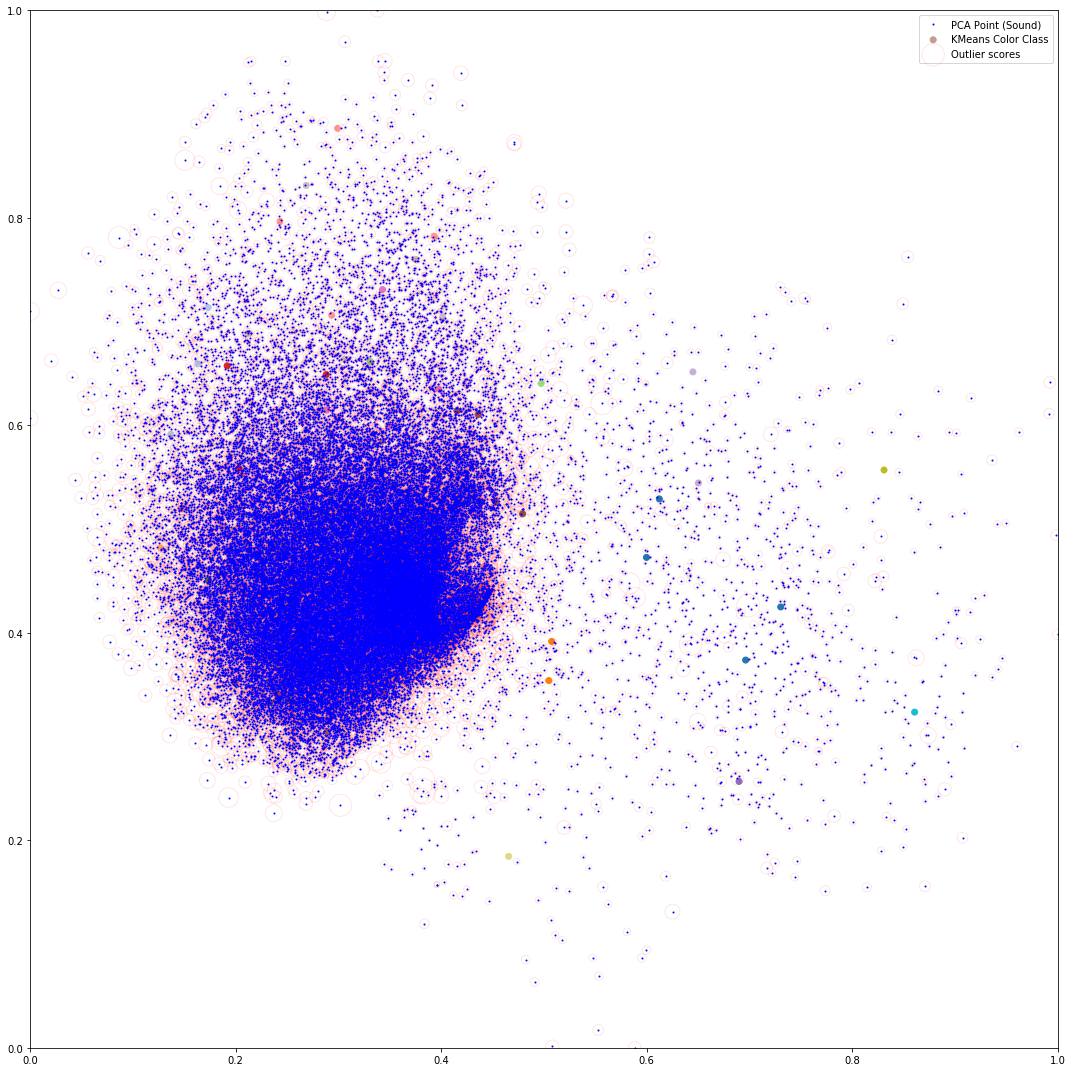

In [12]:
# Calculate PCA and KMeans with raw data (pre)
pre_pca = calculate_pca(data)
pre_kmeans, pre_sound_classes = kmeans_clustering(pre_pca)
pre_clf_scores = identify_outliers(pre_pca)
pre_color_kmeans, pre_color_classes = colorize_clustering(pre_kmeans)

# ... and plot it!
fig_clusters = plot_sounds(pre_kmeans, pre_pca, pre_color_classes, pre_clf_scores)

Removed 90 points (outliers) before=54030, after=53940
PCA variance per dimension (cumulative) = [33.9 55.3 70.2]


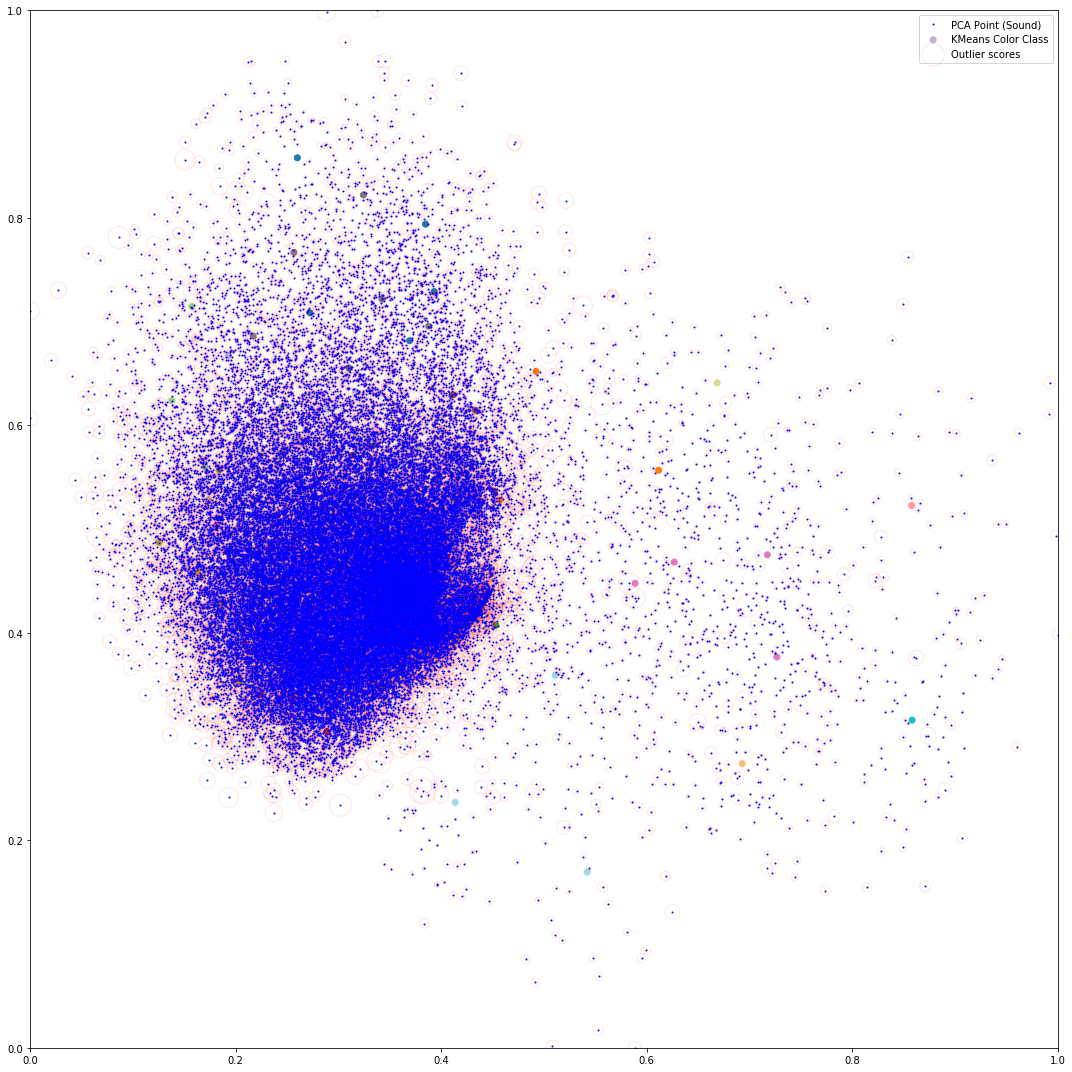

In [13]:
# Remove outliers from the pre calculation ...
filtered_data = data

if args['n_filter_steps'] == 0:
    # Only rename variables when no filtering was needed ..
    pca = pre_pca
    kmeans = pre_kmeans
    sound_classes = pre_sound_classes
    clf_scores = pre_clf_scores
    color_kmeans = pre_color_kmeans
    color_classes = pre_color_classes
    
    print('Skip this step, do not filter outliers ..')

for filter_step in range(args['n_filter_steps']):
    filtered_data = remove_outliers(filtered_data, pre_clf_scores)

    # ... do a new (final) calculation again ..
    pca = calculate_pca(filtered_data)
    kmeans, sound_classes = kmeans_clustering(pca)
    clf_scores = identify_outliers(pca)
    color_kmeans, color_classes = colorize_clustering(kmeans)

# ... and plot it!
if args['n_filter_steps'] > 0:
    fig_clusters = plot_sounds(kmeans, pca, color_classes, clf_scores)

mean = 544.8484848484849, min = 44, max = 1979
classes > mean = 40, classes < mean = 59, ratio = 0.68


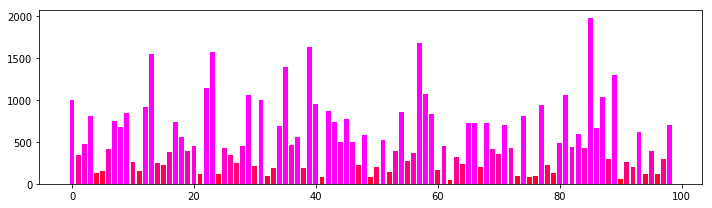

In [14]:
# Print some information about the class distribution
points_per_class = []
for group in range(args['n_clusters']):
    points_per_class.append(
        len(np.where(sound_classes == group)[0]))

mean = np.mean(points_per_class)
maxv = np.max(points_per_class)

print('mean = {}, min = {}, max = {}'.format(mean,
                                             np.min(points_per_class),
                                             maxv))

strong_classes = len(np.where(points_per_class > mean)[0])
weak_classes = len(np.where(points_per_class < mean)[0])

print('classes > mean = {0}, classes < mean = {1}, ratio = {2:.2}'.format(
    strong_classes,
    weak_classes,
    strong_classes / weak_classes))

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Plot classes and class sizes to visualize distribution

bar_colors = [(1, 0, min(p / mean, 1)) for p in points_per_class]
fig_classes = plt.figure(figsize=(10, 3))
plt.bar(np.arange(args['n_clusters']), points_per_class, color=bar_colors)

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot

plt.tight_layout()

In [15]:
# Calculate average volume
rms_data = [x['rms'] for x in filtered_data]
rms_data = rms_data / np.max(rms_data)
kernel = np.array(np.full((args['kernel_size'],), 1)) / args['kernel_size']
rms_avg_data = np.convolve(rms_data, kernel, 'same')
rms_avg_data = rms_avg_data / np.max(rms_avg_data)

In [16]:
def find_duration_class(duration):
    duration_class = args['n_durations'] - 1
    
    for duration_def_class, duration_def in enumerate(args['durations']):
        if duration < duration_def:
            duration_class = duration_def_class
            break
            
    return duration_class

In [17]:
# Add classes and volume information to our data
for i, item in enumerate(filtered_data):
    # Define dynamic class
    rms_avg = np.float32(rms_avg_data[i]).item()
    
    filtered_data[i]['rms'] = np.float32(rms_data[i]).item()
    filtered_data[i]['rms_avg'] = rms_avg

    filtered_data[i]['class_dynamic'] = round(rms_avg * (args['n_dynamics'] - 1))
    
    # Define duration class
    duration = (filtered_data[i]['end'] - filtered_data[i]['start']) / sr * 1000
    filtered_data[i]['duration'] = duration
    filtered_data[i]['class_duration'] = find_duration_class(duration)
    
    # +2 to class for giving silence its own sound class 1
    filtered_data[i]['class_sound'] = np.uint32(sound_classes[i] + 1).item()

In [18]:
filtered_data[0]

{'class_duration': 9,
 'class_dynamic': 2,
 'class_sound': 18,
 'duration': 10611.519274376418,
 'end': 638464,
 'mfcc': [-6.082034795723925,
  0.7532675148046711,
  0.45124044844687905,
  0.4171059459529158,
  0.5719957158962922,
  0.5358176476444967,
  0.23281916895751387,
  -0.006220135248231666,
  0.04743586647727553,
  0.20581722469186572,
  0.17516648708609422,
  -0.019768003061952772,
  -0.11015055733935701,
  0.1096756216046875,
  0.10916535632726904,
  0.10752126515578998,
  0.10751987984041951,
  0.10879213098322295,
  0.10916439881323428,
  0.10813713859331904,
  0.10745633092579338,
  0.10814722512819389,
  0.1090951176748805,
  0.10919440535653296,
  0.10895402953109871,
  0.10903619825133501,
  0.10948437695605547,
  0.10994127038083748,
  0.10975322054655448,
  0.1093068848973926,
  0.10893444550372061,
  0.10881992600946935,
  0.10869670672996193,
  0.10838496893050004,
  0.10807546207027925,
  0.1079951377708723,
  0.10825014238530364,
  0.10879517319349724,
  0.109210

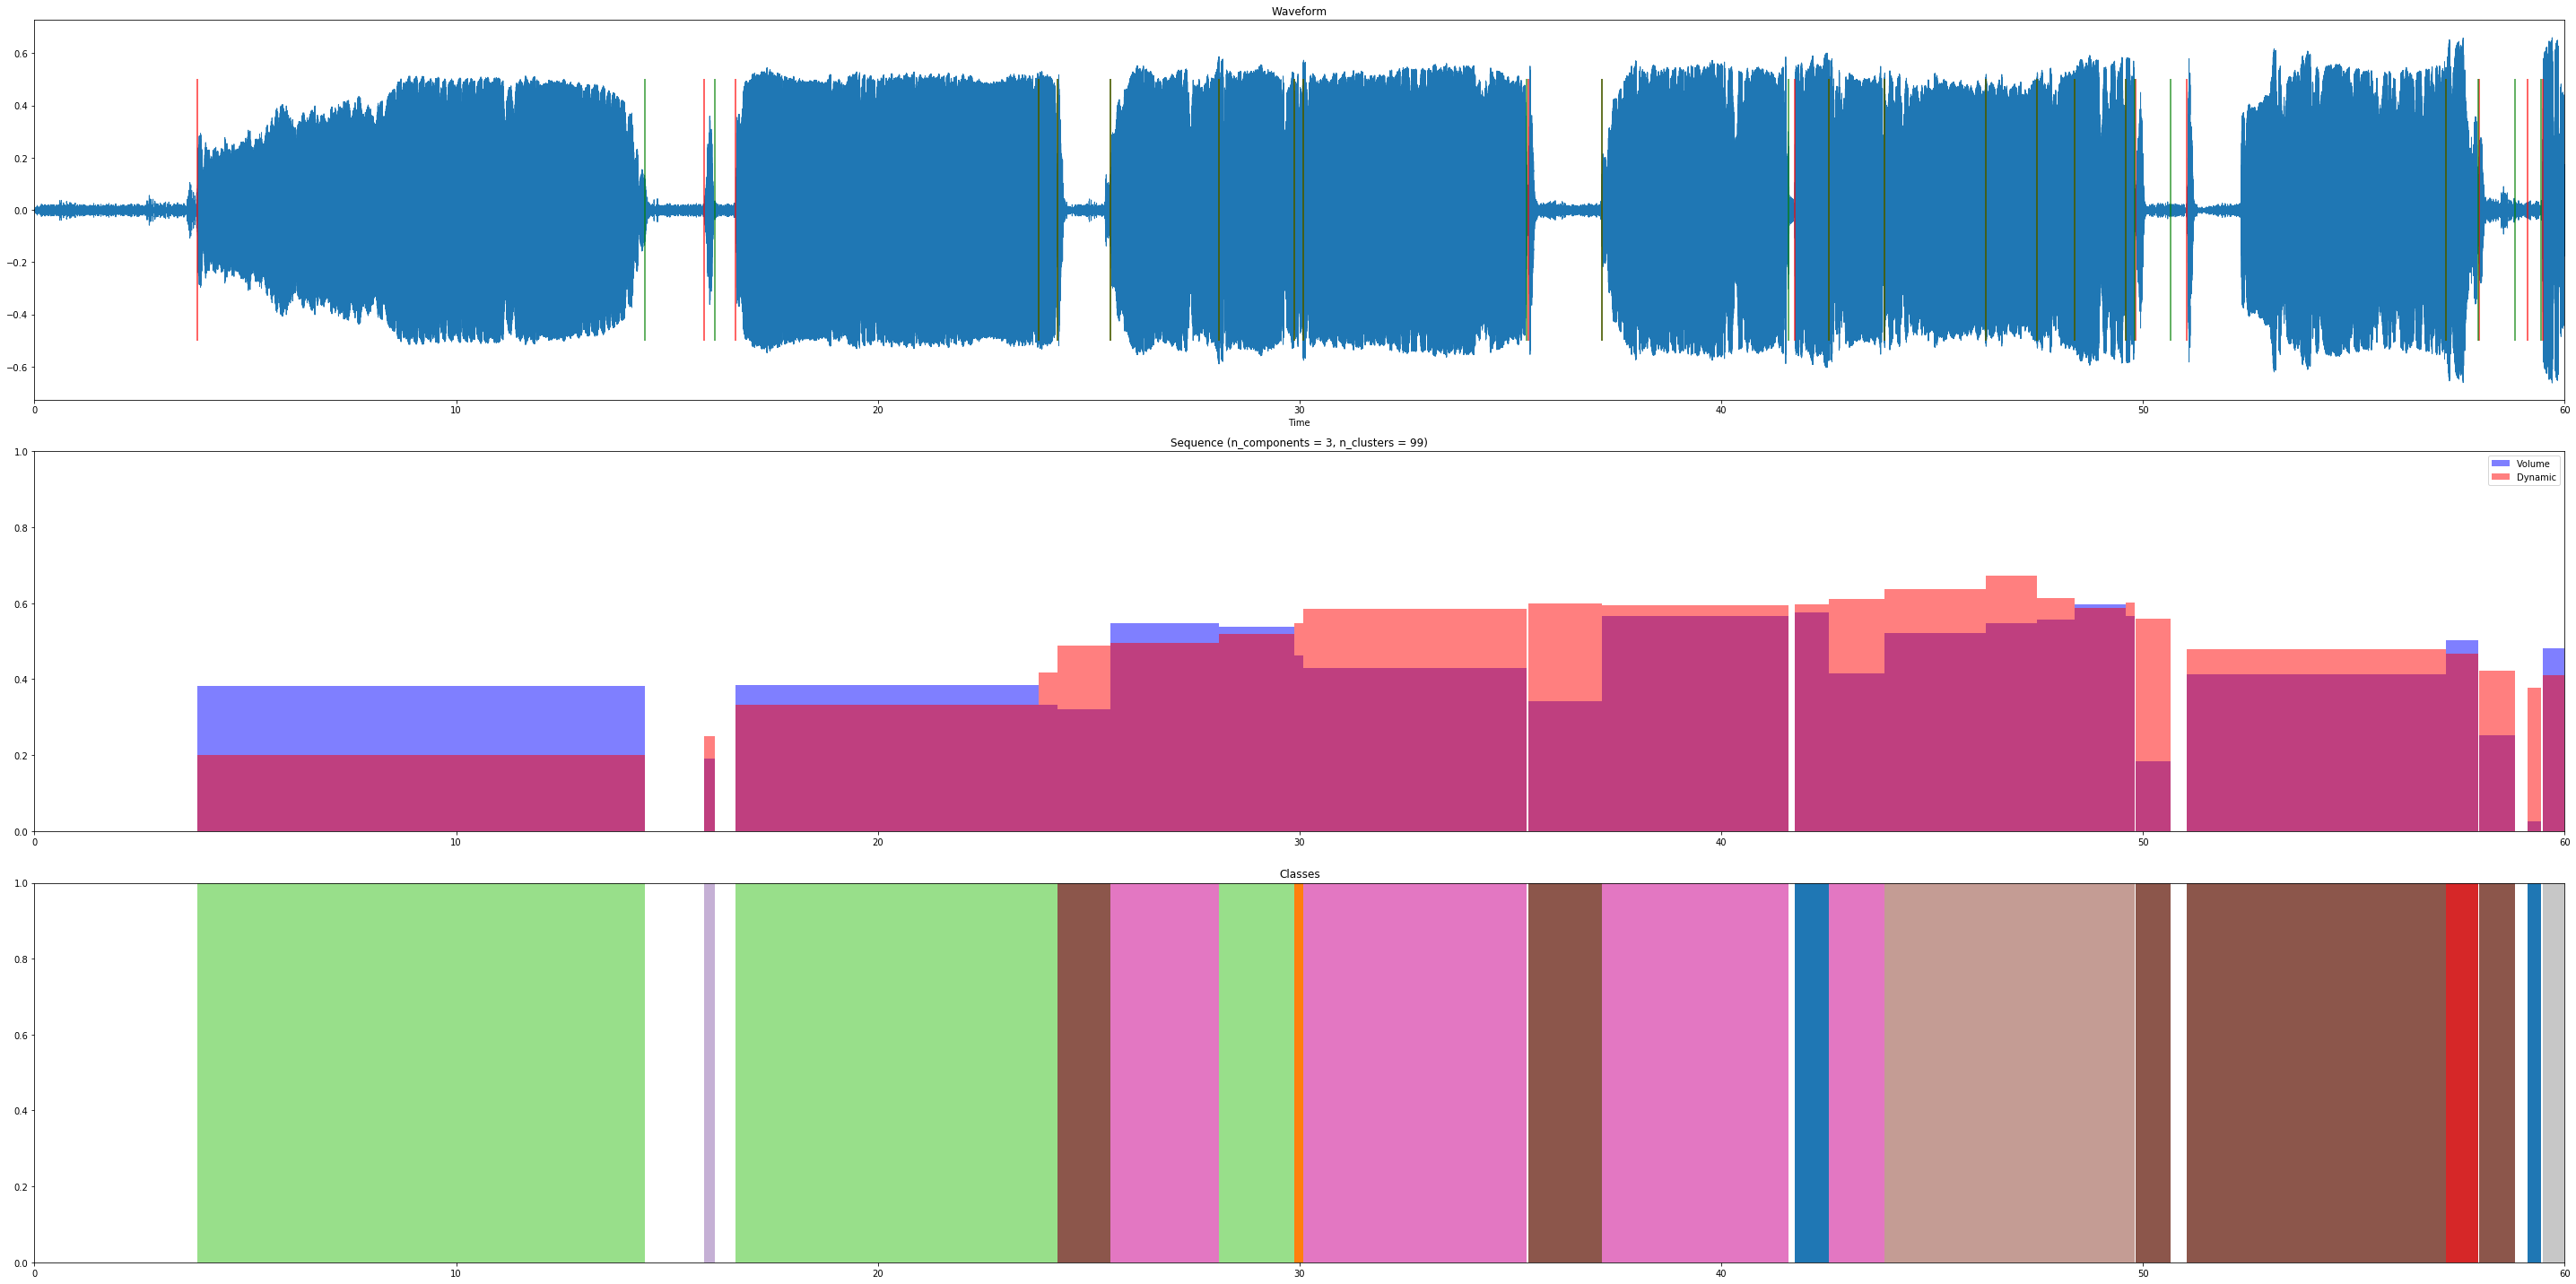

In [19]:
data_slice = 60

# Convert start and end frames
c_starts = np.array([x['start'] for x in filtered_data]) / sr
c_ends = np.array([x['end'] for x in filtered_data]) / sr
c_width = c_ends - c_starts

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Start plot
fig_sequence = plt.figure(figsize=(40, 20))

# 1. Audio waveform
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Load full audio file
y, _ = librosa.load(audio_file_path, sr=sr, duration=data_slice)

# Plot waveform
plt.subplot(3, 1, 1, title="Waveform")
librosa.display.waveplot(y[:data_slice*sr], sr=sr)

# Plot onsets
plt.vlines(c_starts, -0.5, 0.5,
           color='r',
           alpha=0.8)

plt.vlines(c_ends, -0.5, 0.5,
           color='g',
           alpha=0.8)

# 2. Plot sequence
# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Plot sequence
plt.subplot(3, 1, 2, title="Sequence (n_components = {}, n_clusters = {})".format(
    args['n_components'], args['n_clusters']))

plt.axis([0, data_slice, 0, 1])

plt.bar(c_starts, [x['rms'] for x in filtered_data],
        width=c_width,
        align='edge',
        color='blue',
        alpha=0.5,
        label='Volume')

plt.bar(c_starts, [x['rms_avg'] for x in filtered_data],
        width=c_width,
        align='edge',
        color='red',
        alpha=0.5,
        label='Dynamic')

plt.legend(frameon=True)

# 3. Class
# ~~~~~~~~~~~~~~~~~~~~~~~~~

plt.subplot(3, 1, 3, title="Classes")

plt.axis([0, data_slice, 0, 1])

# Color them to indicate similarity between classes
bar_color = [scalar_map.to_rgba(color_classes[c['class_sound'] - 2]) for c in filtered_data]

plt.bar(c_starts, 1,
        width=c_width,
        align='edge',
        color=bar_color,
        label='Class')

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot
plt.tight_layout()

In [20]:
# Find silence in and in-between sound events
sequence = []
last_step = filtered_data[0]
id_counter = 1

for step_index, step in enumerate(filtered_data):
    duration_between = ((step['start'] - last_step['end']) / sr) * 1000

    # Add silence between sound events
    if duration_between >= (args['durations'][0] / 2):
        silence_step = {
            'id': id_counter,
            'class_duration': find_duration_class(duration_between),
            'class_dynamic': 0,
            'class_sound': SILENCE_CLASS,
            'rms': 0,
            'rms_avg': 0,
            'start': str(last_step['end']),
            'end': str(step['start']),
            'duration': duration_between,
        }

        sequence.append(silence_step)

        id_counter += 1
        
    converted_step = step.copy()
    converted_step['id'] = id_counter
    
    # Convert long integers (64bit) to strings
    converted_step['start'] = str(converted_step['start'])
    converted_step['end'] = str(converted_step['end'])
    
    # Set to silent class when dynamics are 0
    if converted_step['class_dynamic'] == 0:
        converted_step['class_sound'] = SILENCE_CLASS

    sequence.append(converted_step)
        
    id_counter += 1
    last_step = step

# Combine events and steps into one dataset
dataset = {
    'version': VERSION,
    'meta': {
        'samplerate': sr,
    },
    'args': args,
    'sequence': sequence,
}

print('Generated sequence with {} events'.format(len(sequence)))

Generated sequence with 72899 events


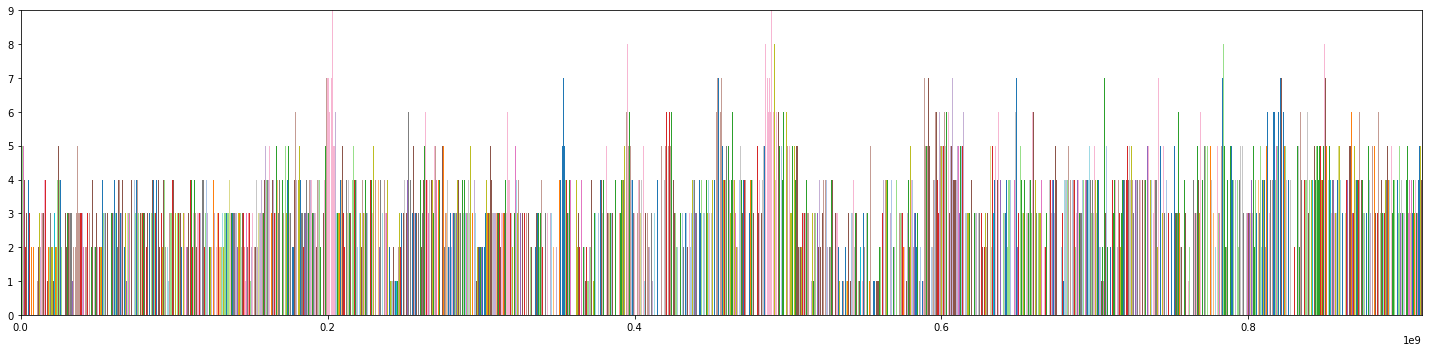

In [21]:
sequence_slice = sequence

# ~~~~~~~~~~~~~~~~~~~~~~~~~
    
# Prepare plot

fig_dataset = plt.figure(figsize=(20, 5))

plt.axis([0, int(sequence_slice[-1]['end']), 0, args['n_dynamics'] - 1])

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Colorcode sequence with clustered classes, use white for silence
bar_color = [(1, 1, 1, 1) if s['class_sound'] is SILENCE_CLASS else scalar_map.to_rgba(
    color_classes[s['class_sound'] - 2]
) for s in sequence_slice]

# Display dynamics and durations
width_durations = [int(s['end']) - int(s['start']) for s in sequence_slice]
heights_dynamics = [s['class_dynamic'] for s in sequence_slice]

# Plot all steps in sequence
plt.bar([int(s['start']) for s in sequence_slice],
        heights_dynamics,
        width=width_durations,
        align='edge',
        color=bar_color,
        label='Timestep Classes')

# ~~~~~~~~~~~~~~~~~~~~~~~~~

# Finalize plot

plt.tight_layout()

In [22]:
base_name = '{}cls-{}pca-{}db'.format(args['n_clusters'],
                                      args['n_components'],
                                      args['trim_top_db'])

dataset_name = '{}-{}.json'.format(experiment_name, base_name)
dataset_path = os.path.join(os.getcwd(), 'files', 'mono-experiment', dataset_name)

# Save dataset as .json file
with open(dataset_path, 'w') as file:
    json.dump(dataset, file, indent=2, separators=(',', ': '))

In [23]:
def save_figure(fig, name):
    fig_name = '{}-{}-plot-{}.png'.format(experiment_name, base_name, name)
    fig_path = os.path.join(os.getcwd(), 'files', 'mono-experiment', fig_name)
    
    fig.savefig(fig_path, bbox_inches='tight')
    
# Save plots for validation
save_figure(fig_clusters, 'clusters')
save_figure(fig_classes, 'classes')
save_figure(fig_sequence, 'sequence')
save_figure(fig_dataset, 'dataset')

print('Done with "{}"!'.format(dataset_name))

Done with "tomomi-original-99cls-3pca-10db.json"!
